# Working with IMPC Statistical Results Data

Statistical results are the main output of the IMPC Data Analysis Pipeline, we use statistical results to generate gene-phenotype associations or hits.

In [1]:
import urllib.request
import gzip
import pandas as pd

1. Download the Statistical Results report from the [latest Data Release](https://ftp.ebi.ac.uk/pub/databases/impc/all-data-releases/latest/results/statistical-results-ALL.csv.gz) (may take a while is aroung 2.7GB when uncompressed).

In [3]:
stats_results_url = "https://ftp.ebi.ac.uk/pub/databases/impc/other/statistical-results-ALL.csv.gz"
# This URL is temporary plesae use the one below after the IMPC has fixed the issue with the stats results file
# stats_results_url = "https://ftp.ebi.ac.uk/pub/databases/impc/all-data-releases/latest/results/statistical-results-ALL.csv.gz"
stats_results_file_name = "data/statistical-results-ALL.csv.gz"
urllib.request.urlretrieve(stats_results_url, stats_results_file_name)

2. Open the file

In [4]:
with gzip.open(stats_results_file_name) as stats_results_file:
    stats_results = pd.read_csv(stats_results_file)

/var/folders/23/5lgvty8d0js7s4d5qw017r340000gp/T/ipykernel_46165/2223263253.py:2: DtypeWarning: Columns (25,60) have mixed types. Specify dtype option on import or set low_memory=False.
  stats_results = pd.read_csv(stats_results_file)


3. Check the file structure

In [5]:
stats_results.head()

,phenotyping_center,intercept_estimate,procedure_id,mutant_biological_model_id,rotated_residuals_test,weight_effect_p_value,male_mutant_count,pipeline_stable_key,female_ko_effect_p_value,pipeline_stable_id,...,pipeline_id,group_1_genotype,male_ko_parameter_estimate,genotype_effect_parameter_estimate,categories,parameter_id,batch_significant,genotype_effect_stderr_estimate,resource_fullname,significant
0,HMGU,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,HMGU_001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMPC,False
1,ICS,420.169756,NaN,NaN,NaN,NaN,8.0,10,0.667601,ICS_001,...,NaN,control,5.753204,-0.106308,NaN,NaN,False,9.789624,IMPC,False
2,BCM,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,BCM_001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMPC,False
3,ICS,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,ICS_001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMPC,False
4,UC Davis,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,UCD_001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMPC,False


4. Filter out legacy / external projects data (optional). The [mousephenotype.org](mousephenotype.org) website has data for some legacy phenotyping projects (like MGP and EuroPhenome) and some especial collaboration projects (like the 3i Comsortium). Also filter out statistical results without top_level_mp_term, so statistical results are annotated with a different ontology, for some really specific procedures.

In [6]:
impc_stats_results = stats_results[(stats_results.resource_fullname == "IMPC") & (~stats_results.top_level_mp_term_name.isna())]

5. Split the nested list of top_level_mp_term_names and explode the dataframe, so we have one value for top_level_mp_term_name in every row.

In [7]:
impc_stats_results.top_level_mp_term_name = impc_stats_results.top_level_mp_term_name.str.split(",")
impc_stats_results_top_level_exploded = impc_stats_results.explode("top_level_mp_term_name")

/var/folders/23/5lgvty8d0js7s4d5qw017r340000gp/T/ipykernel_46165/3174311107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impc_stats_results.top_level_mp_term_name = impc_stats_results.top_level_mp_term_name.str.split(",")


In [12]:
impc_gene_phenotype_assoc = impc_stats_results_top_level_exploded[["marker_symbol", "top_level_mp_term_name", "significant"]].drop_duplicates()
impc_gene_phenotype_top_level_tested_vs_hits = impc_gene_phenotype_assoc.groupby(["marker_symbol", "top_level_mp_term_name"], as_index=False).any("significant").groupby(["top_level_mp_term_name", "significant"], as_index=False).nunique("marker_symbol").sort_values("marker_#symbol", ascending=False)

<Axes: title={'center': 'IMPC gene-phenotype associations tested vs hits'}, xlabel='top_level_mp_term_name'>

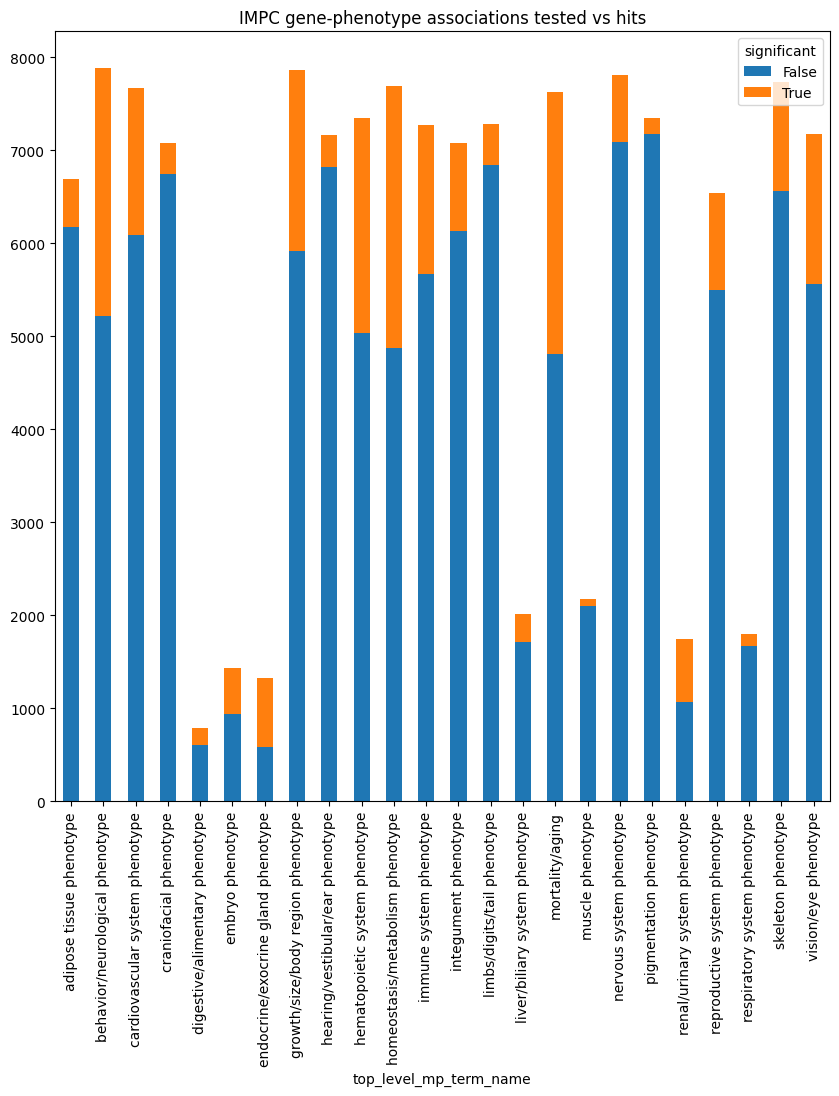

In [17]:
impc_gene_phenotype_top_level_tested_vs_hits.pivot_table(index="top_level_mp_term_name", columns="significant", values="marker_symbol", aggfunc="sum").plot.bar(title="IMPC gene-phenotype associations tested vs hits", figsize=(10, 10), stacked=True)
#impc_gene_phenotype_top_level_tested_vs_hits.plot.barh(x="top_level_mp_term_name", y="marker_symbol", color="significant", title="IMPC gene-phenotype associations tested vs hits", figsize=(10, 10))